In [21]:
%matplotlib inline

import numpy as np
import pandas as pd
import string
import nltk
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

nltk.download('stopwords')

from imblearn.over_sampling import SMOTE

from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
raw_data = pd.read_csv("data/winemag-data-130k-v2.csv")
raw_descriptions = raw_data['description']
raw_varieties = raw_data['variety']
raw_provinces = raw_data['province']
raw_points = raw_data['points']

In [3]:
len(set(raw_descriptions))

119955

In [4]:
valid_varieties = set(['pinot noir', 'chardonnay', 'cabernet sauvignon', 'riesling', 'sauvignon blanc', 'syrah', 'rosé', 'merlot', 'nebbiolo', 'zinfandel', 'sangiovese', 'malbec']) #, 'portuguese red', 'white blend', 'sparkling blend', 'tempranillo', 'rhône-style red blend', 'pinot gris', 'champagne blend', 'cabernet franc', 'grüner veltliner', 'portuguese white', 'bordeaux-style white blend', 'pinot grigio', 'gamay', 'gewürztraminer', 'viognier', 'shiraz'])
excluded_words = set(['pinot', 'noir', 'chardonnay', 'cabernet', 'sauvignon', 'bordeaux-style', 'blend', 'riesling', 'sauvignon',  'blanc', 'syrah', 'rosé', 'merlot', 'nebbiolo', 'zinfandel', 'sangiovese', 'malbec', 'portuguese', 'tempranillo', 'rhône-style', 'pinot', 'gris', 'champagne', 'franc', 'grüner',  'veltliner', 'portuguese', 'grigio', 'gamay', 'gewürztraminer', 'viognier', 'shiraz', 'flavor', 'wine'])

varieties = ['pinot noir', 'chardonnay', 'cabernet sauvignon', 'riesling', 'sauvignon blanc', 'syrah', 'rosé', 'merlot', 'nebbiolo', 'zinfandel', 'sangiovese', 'malbec']
label_to_idx = {word: idx for idx, word in enumerate(varieties)}
print(label_to_idx)

{'pinot noir': 0, 'chardonnay': 1, 'cabernet sauvignon': 2, 'riesling': 3, 'sauvignon blanc': 4, 'syrah': 5, 'rosé': 6, 'merlot': 7, 'nebbiolo': 8, 'zinfandel': 9, 'sangiovese': 10, 'malbec': 11}


In [5]:
# Extract rows with just the valid varieties

def process_description(des):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    processed_description = []
    
    table = str.maketrans({key: None for key in string.punctuation})
    des = des.translate(table)
    
    for word in des.split():
        word = word.lower()
        word = stemmer.stem(word)
        if word not in excluded_words:
            processed_description.append(word)
            
    return " ".join(processed_description)

data, labels = [], []
for i, variety in enumerate(raw_varieties):
    if type(variety) is not float:
        variety = variety.lower()
        if variety.lower() in valid_varieties:
            if type(raw_descriptions[i]) is not float:                
                data.append(process_description(raw_descriptions[i]))
                labels.append(variety)

print(len(data), len(labels))

66338 66338


In [6]:
# Print a sample of the data

print(data[:5])

['pineappl rind lemon pith and orang blossom start off the aroma the palat is a bit more opul with note of honeydrizzl guava and mango give way to a slight astring semidri finish', 'much like the regular bottl from 2012 this come across as rather rough and tannic with rustic earthi herbal characterist nonetheless if you think of it as a pleasant unfussi countri its a good companion to a hearti winter stew', 'soft suppl plum envelop an oaki structur in this support by 15 coffe and chocol complet the pictur finish strong at the end result in a valuepr of attract and immedi access', 'slight reduc this offer a chalki tannic backbon to an otherwis juici explos of rich black cherri the whole accent throughout by firm oak and cigar box', 'build on 150 year and six generat of winemak tradit the wineri trend toward a leaner style with the classic california buttercream aroma cut by tart green appl in this good everyday sip that rang from pear to bare ripe pineappl prove approach but not distinc

In [7]:
# Split 80/20 training-test

stacked = np.hstack([np.array(data).reshape(-1, 1), np.array(labels).reshape(-1, 1)])
np.random.shuffle(stacked)

train_split = int(len(stacked) * 0.8)

train_data = stacked[:train_split, :1].reshape(-1,)
train_labels = stacked[:train_split, 1:].reshape(-1,)

test_data = stacked[train_split:, :1].reshape(-1,)
test_labels = stacked[train_split:, 1:].reshape(-1,)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(53070,) (53070,)
(13268,) (13268,)


In [8]:
def resample(data, labels):
    return SMOTE().fit_sample(train_data, train_labels)

In [9]:
# Compile vocabulary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tf_idf_vectorizer = TfidfVectorizer(stop_words='english', token_pattern='[a-z]+', ngram_range=(1, 1))

# tokenize and build vocab
tf_idf_vectorizer.fit(train_data)

# summarize
print(len(tf_idf_vectorizer.vocabulary_))

count_vectorizer = CountVectorizer(stop_words='english', token_pattern='[a-z]+', ngram_range=(1, 2))
count_vectorizer.fit(train_data)

print(len(count_vectorizer.vocabulary_))

19830
380976


In [10]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB

def multinomial_nb(vectorizer, train_data, train_labels, test_data, test_labels):
    clf = MultinomialNB()
    clf.fit(vectorizer.transform(train_data), train_labels)
    return clf.score(vectorizer.transform(test_data), test_labels)

In [11]:
# Dummy Classifier

from sklearn.dummy import DummyClassifier

def dummy_classifier(vectorizer, train_data, train_labels, test_data, test_labels):
    dummy_clf = DummyClassifier()
    dummy_clf.fit(vectorizer.transform(train_data), train_labels)
    return dummy_clf.score(vectorizer.transform(test_data), test_labels)

In [12]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

def logistic_regression(vectorizer, train_data, train_labels, test_data, test_labels):
    lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    lr.fit(vectorizer.transform(train_data), train_labels)
    return lr.score(vectorizer.transform(test_data), test_labels)

In [13]:
from sklearn.svm import LinearSVC

def svc(vectorizer, train_data, train_labels, test_data, test_labels):
    clf = LinearSVC()
    clf.fit(vectorizer.transform(train_data), train_labels)
    return clf.score(vectorizer.transform(test_data), test_labels)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def knn(vectorizer, train_data, train_labels, test_data, test_labels):
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(vectorizer.transform(train_data), train_labels)
    return neigh.score(vectorizer.transform(test_data), test_labels)

In [18]:
def run_experiments():
    # Bag of words
    count_vectorizer = CountVectorizer(stop_words='english', token_pattern='[a-z]+', ngram_range=(1, 1))
    count_vectorizer.fit(train_data)

#     print(multinomial_nb(count_vectorizer, train_data, train_labels, test_data, test_labels))
#     print(logistic_regression(count_vectorizer, train_data, train_labels, test_data, test_labels))
#     print(svc(count_vectorizer, train_data, train_labels, test_data, test_labels))
    print(knn(count_vectorizer, train_data, train_labels, test_data, test_labels))

    # Bigrams
    count_vectorizer = CountVectorizer(stop_words='english', token_pattern='[a-z]+', ngram_range=(1, 2))
    count_vectorizer.fit(train_data)

#     print(multinomial_nb(count_vectorizer, train_data, train_labels, test_data, test_labels))
#     print(logistic_regression(count_vectorizer, train_data, train_labels, test_data, test_labels))
#     print(svc(count_vectorizer, train_data, train_labels, test_data, test_labels))
    print(knn(count_vectorizer, train_data, train_labels, test_data, test_labels))


In [19]:
run_experiments()

0.4332981609888453
0.2805999397045523


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def validation_stats():
    count_vectorizer = CountVectorizer(stop_words='english', token_pattern='[a-z]+', ngram_range=(1, 2))
    count_vectorizer.fit(train_data)
    
    lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    lr.fit(count_vectorizer.transform(train_data), train_labels)

    cnf_matrix = confusion_matrix(test_labels, lr.predict(count_vectorizer.transform(test_data)))
        
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix, classes=varieties,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix, classes=varieties, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
    return cnf_matrix

Confusion matrix, without normalization
Normalized confusion matrix


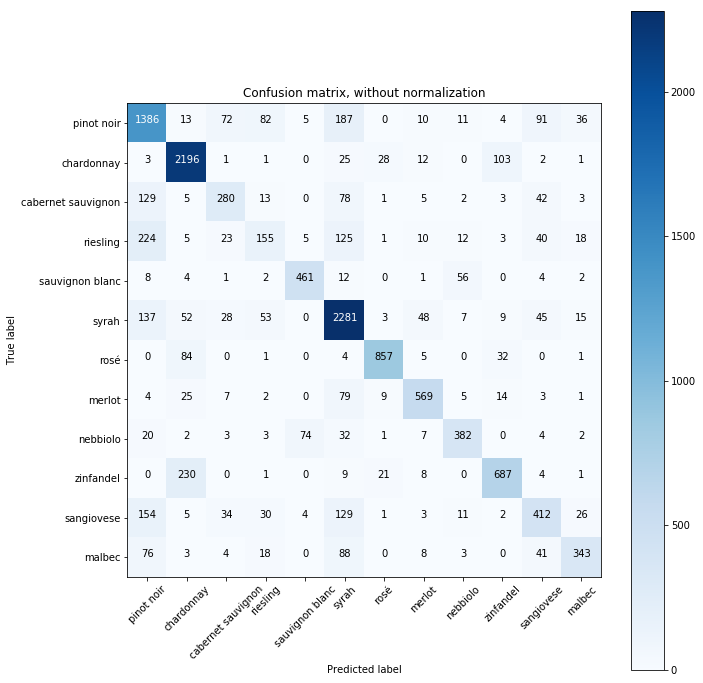

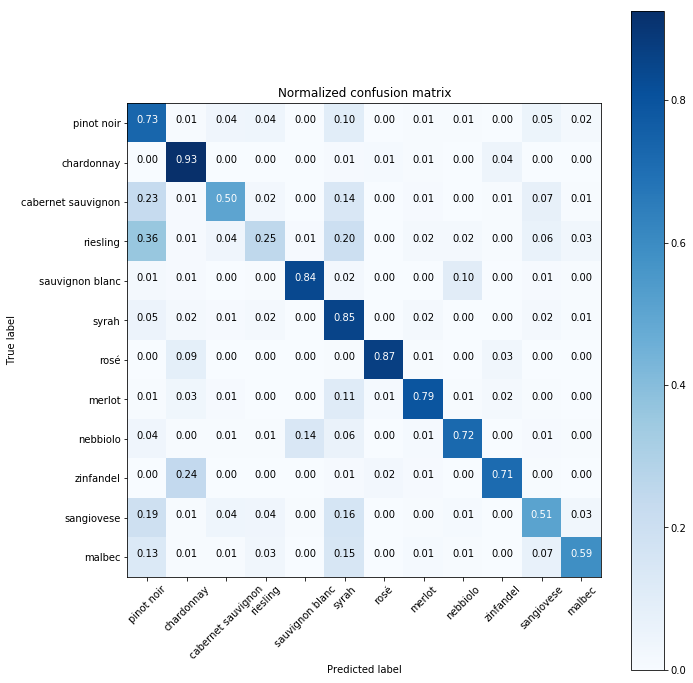

array([[1386,   13,   72,   82,    5,  187,    0,   10,   11,    4,   91,
          36],
       [   3, 2196,    1,    1,    0,   25,   28,   12,    0,  103,    2,
           1],
       [ 129,    5,  280,   13,    0,   78,    1,    5,    2,    3,   42,
           3],
       [ 224,    5,   23,  155,    5,  125,    1,   10,   12,    3,   40,
          18],
       [   8,    4,    1,    2,  461,   12,    0,    1,   56,    0,    4,
           2],
       [ 137,   52,   28,   53,    0, 2281,    3,   48,    7,    9,   45,
          15],
       [   0,   84,    0,    1,    0,    4,  857,    5,    0,   32,    0,
           1],
       [   4,   25,    7,    2,    0,   79,    9,  569,    5,   14,    3,
           1],
       [  20,    2,    3,    3,   74,   32,    1,    7,  382,    0,    4,
           2],
       [   0,  230,    0,    1,    0,    9,   21,    8,    0,  687,    4,
           1],
       [ 154,    5,   34,   30,    4,  129,    1,    3,   11,    2,  412,
          26],
       [  76,    3,  

In [27]:
validation_stats()

In [34]:
import itertools
import numpy as np

from sklearn import svm, linear_model, cross_validation


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking
    Transforms a n-class ranking problem into a two-class classification
    problem. Subclasses implementing particular strategies for choosing
    pairs should override this method.
    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,) or (n_samples, 2)
        Target labels. If it's a 2D array, the second column represents
        the grouping of samples, i.e., samples with different groups will
        not be considered.
    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Data as pairs
    y_trans : array, shape (k,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return np.asarray(X_new), np.asarray(y_new).ravel()


class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        """
        Fit a pairwise ranking model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        Returns
        -------
        ord : array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
            return np.argsort(np.dot(X, self.coef_.T).ravel())
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans)

In [ ]:
numerical_train_labels = []
numerical_test_labels = []

for label in train_labels:
    numerical_train_labels.append(label_to_idx[label])
    
for label in test_labels:
    numerical_test_labels.append(label_to_idx[label])  
    
tfidf_vectorizer = TfidfVectorizer(stop_words='english', token_pattern='[a-z]+', ngram_range=(1, 2))
tfidf_vectorizer.fit(train_data)

svm = RankSVM()
svm.fit(tfidf_vectorizer.transform(train_data), numerical_train_labels)
svm.score(tfidf_vectorizer.transform(test_data), numerical_test_labels)